In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 27.0 MB/s 
     |████████████████████████████████| 81 kB 10.0 MB/s 
     |████████████████████████████████| 209 kB 67.3 MB/s 
     |████████████████████████████████| 78 kB 7.7 MB/s 
     |████████████████████████████████| 112 kB 65.6 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
     |████████████████████████████████| 147 kB 50.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=84ad4cc9f8ebeb3f0fbef6f331e06c642dd67f8c350b2878b10aef4f62d09aac
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 27.7 MB/s 


In [ ]:
!pip install comet-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 23.0 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 498 kB 63.7 MB/s 
     |████████████████████████████████| 166 kB 16.0 MB/s 
     |████████████████████████████████| 140 kB 62.5 MB/s 
     |████████████████████████████████| 127 kB 31.8 MB/s 
     |████████████████████████████████| 166 kB 51.5 MB/s 
     |████████████████████████████████| 162 kB 57.3 MB/s 
     |████████████████████████████████| 162 kB 54.1 MB/s 
     |████████████████████████████████| 158 kB 52.6 MB/s 
     |████████████████████████████████| 157 kB 34.9 MB/s 
     |████████████████████████████████| 157 kB 48.7 MB/s 
     |████████████████████████████████| 157 kB 57.2 MB/s 
     |████████████████████████████████| 157 kB 31.5 MB/s 
     |█████████████████████████████

In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import os

# XGBoost Library
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn library for basic processing
from sklearn.model_selection import train_test_split

# accuracy, roc, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# One hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# Datetime
from datetime import datetime

# Plotting curves
from matplotlib import pyplot
import seaborn as sns
from sklearn.calibration import calibration_curve, CalibrationDisplay

# Grid Search and hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
import optuna
import sklearn.datasets
import sklearn.metrics

# Feature Selection Library
from sklearn.feature_selection import RFECV
import shap

# Comet Experiment
from comet_ml import Experiment
import configparser

# Hide warnings
import warnings
warnings.filterwarnings('ignore')
# Maintain reproducibility in accuracies
np.random.seed(42)

In [ ]:
# Importing comet.ml
config = configparser.ConfigParser()
'''
File location of your key file, it can be placed anywhere but it should not the 
part of git due to privacy and security purposes
'''
config.read('keys\\comet_ml.ini')
API_KEY = config['comet_ml']['api_key']
PROJECT_NAME = config['comet_ml']['project_name']
WORKSPACE = config['comet_ml']['workspace']

In [ ]:
def dataload(train_link):
  """
  This function is for loading the dataset.
  params: train_link
  return train_df
  """
  train_df = pd.read_csv(train_link)
  train_df.rename(columns={'game date':'game_date', 'period time':'period_time',
                           'game id':'game_id','home team':'home_team', 
                           'away team':'away_team', 'is goal':'is_goal', 
                           'team shot':'team_shot', 'x shot':'x_shot', 
                           'y shot':'y_shot', 'shot type':'shot_type', 
                           'empty net':'empty_net', 'home goal':'home_goal', 
                           'away goal':'away_goal', 'is rebound':'is_rebound', 
                           'game seconds':'game_seconds', 
                           'last event type':'last_event_type', 
                           'x last event':'x_last_event',
                           'y last event':'y_last_event', 
                           'time from last event':'time_from_last_event', 
                           'num player home':'num_player_home', 
                           'num player away':'num_player_away', 
                           'time power play':'time_power_play', 
                           'shot distance':'shot_distance', 
                           'shot angle':'shot_angle', 
                           'change in shot angle':'change_in_shot_angle', 
                           'distance from last event':'distance_from_last_event'
                           }, inplace=True)
  return train_df

In [ ]:
def data_preprocess(model_type, train_df, features=None):
  """
  This function is for preprocessing of the dataset. It will perform the 
  preprocessing based on the model-type. Model-type could be base, 
  more_features, or tuned, feature_selection.
  params: model_type, train_df, features
  return transformed_X, y_numeric
  """
  # Define target
  y = train_df.is_goal
  y_numeric = np.where(y == False, 0, 1)
  y_numeric = pd.DataFrame(y_numeric, columns={'is_goal'})

  if model_type == 'base':
    X = train_df[['shot_distance','shot_angle']]
    return X, y_numeric
  elif model_type == 'more_features' or model_type == 'tuned':
    X = train_df[['game_seconds', 'shot_distance', 'shot_angle', 'period', 
                  'x_shot', 'y_shot', 'shot_type', 'last_event_type', 
                  'x_last_event', 'y_last_event', 'time_from_last_event', 
                  'distance_from_last_event', 'is_rebound', 
                  'change_in_shot_angle', 'speed']]
    X['is_rebound'] = np.where(X['is_rebound'] == False, 0, 1)
    # One hot-encoding for categorical variables
    transformer = make_column_transformer(
        (OneHotEncoder(), ['shot_type', 'last_event_type']), 
        remainder='passthrough')
    transformed = transformer.fit_transform(X)
    transformed_X = pd.DataFrame(transformed, 
                                 columns=transformer.get_feature_names())
    return transformed_X, y_numeric
  elif model_type == 'feature_selection' and features != None and len(features) > 0:
    X = train_df[features]
    if 'is_rebound' in X.columns:
      X['is_rebound'] = np.where(X['is_rebound'] == False, 0, 1)
    # One hot-encoding for categorical variables
    if 'shot_type' in X.columns or 'last_event_type'  in X.columns:
      transformer = make_column_transformer(
          (OneHotEncoder(), ['shot_type', 'last_event_type']), 
          remainder='passthrough')
      transformed = transformer.fit_transform(X)
      transformed_X = pd.DataFrame(transformed, 
                                   columns=transformer.get_feature_names())
    else:
      transformed_X = X.copy()
    return transformed_X, y_numeric

In [ ]:
def model_train_predict(model_type, X, y_numeric, params=None):
  """ 
  This function is for model training and prediction, it is based on the nature 
  of base, more_features, tuned, and feature_selection model types.
  params: model_type, X, y_numeric, params
  return: xgb_probs, y_test, y_pred, X_test, model, accuracy
  """
  X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, 
                                                      test_size=0.2)
  if model_type == 'base' or model_type == 'more_features':
    model = XGBClassifier()
  elif model_type == 'tuned' or model_type == 'feature_selection':
    model = XGBClassifier()
    model.set_params(**params)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]
  accuracy = accuracy_score(y_test, predictions)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  probs = model.predict_proba(X_test)
  # keep probabilities for the positive outcome only
  xgb_probs = probs[:, 1]
  return xgb_probs, y_test, y_pred, X_test, model, accuracy

In [ ]:
def plot_roc_auc_curve(model_type, xgb_probs, y_test, y_pred):
  """
  This will plot the ROC AUC curve.
  params:  xgb_probs, y_test, y_pred
  return:  fig_roc_auc
  """
  fpr, tpr, _ = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)# generate a no skill prediction (majority class)
  # Source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
  ns_probs = [0 for _ in range(len(y_test))]
  # calculate scores
  ns_auc = roc_auc_score(y_test, ns_probs)
  xgb_auc = roc_auc_score(y_test, xgb_probs)
  # summarize scores
  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
  # plot the roc curve for the model
  fig_roc_auc = pyplot.figure()
  pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color='green')
  pyplot.plot(xgb_fpr, xgb_tpr, linestyle='-', label='XGBoost', color='red')
  # axis labels
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  # show the legend
  pyplot.legend()
  # show the plot
  # pyplot.show()
  return fig_roc_auc

In [ ]:
def plot_goal_rate_shot_probab(model_type, xgb_probs, y_test):
  """
  This function will plot the goal rate versus shot probability percentile curve.
  params:  xgb_probs, y_test
  return:  fig_goal_rate
  """
  # Convert 2-D to 1-D series
  new_series = np.array(y_test)
  new_series = np.reshape(new_series, (new_series.shape[0]))

  # Scale true_probabilities (predict_proba() returns true and false both) on percentile
  true_prob = pd.DataFrame()
  true_prob['true_target'] = np.array(new_series)
  percentile = [[np.percentile(xgb_probs, i), np.percentile(xgb_probs, i+5)] 
                for i in range(0,100,5)]
  total_goal = np.sum(new_series)

  # Looping on probabilities to check their percentiles with their status as goal/shot
  goal_probability = []
  for i in range(0, len(percentile)):
      # Check the interval of probability in percentile and calculate the number of goals
      goals = true_prob[ (xgb_probs<=percentile[i][1]) 
      & (xgb_probs>percentile[i][0]) & (true_prob['true_target']==1)].shape[0]
      # Check the interval of probability in percentile and calculate the number of no goals (or shots)
      no_goals = true_prob[(xgb_probs<=percentile[i][1]) 
      & (xgb_probs>percentile[i][0]) & (true_prob['true_target']==0)].shape[0]
      # If no goal, do nothing, calculate the formula if goal
      if goals == 0:
          goal_probability.append(0)
      else:
          goal_probability.append((goals*100)/(goals+no_goals))

  # Axis for percentile
  shot_prob_model_percentile = np.arange(0, 100, 5)
      
  # Plot of goal rate vs Shot probability percentile
  fig_goal_rate = pyplot.figure()
  sns.set()
  pyplot.plot(shot_prob_model_percentile, goal_probability, label='XGBoost')
  pyplot.xlim(100, 0)
  pyplot.ylim(0, 100)
  pyplot.title("Goal Rate")
  pyplot.xlabel('Shot probability model percentile', fontsize=14)
  pyplot.xticks([0,10,20,30,40,50,60,70,80,90,100])
  pyplot.ylabel('Goals / (Shots + Goals)', fontsize=14)
  y_axis = [0,10,20,30,40,50,60,70,80,90,100]
  y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
  pyplot.yticks(y_axis, y_values)
  pyplot.legend()
  return fig_goal_rate

In [ ]:
def plot_cumulative_shot_probab(model_type, xgb_probs, y_test):
  """
  This function will plot the cumulative shot probability curve.
  params:  xgb_probs, y_test
  return:  fig_cum_shot
  """
  # Convert 2-D to 1-D series
  new_series = np.array(y_test)
  new_series = np.reshape(new_series, (new_series.shape[0]))

  # Scale true_probabilities (predict_proba() returns true and false both) on percentile
  true_prob = pd.DataFrame()
  true_prob['true_target'] = np.array(new_series)
  percentile = [[np.percentile(xgb_probs, i), np.percentile(xgb_probs, i+1)] 
                for i in range(0,100,1)]
  total_goal = np.sum(new_series)

  # Looping on probabilities to check their percentiles with their status as goal/shot
  cum_prop = []
  for i in range(0, len(percentile)-1):
      # We need previous and current goal lie in the percentile
      goals = true_prob[(xgb_probs>=percentile[i][0]) 
      & (true_prob['true_target']==1)].shape[0]
      # If no goal, do nothing, calculate the formula if goal
      cum_prop.append(goals*100/total_goal)
  cum_prop.append(0)

  # Axis for percentile
  shot_prob_model_percentile = np.arange(0, 100, 1)
      
  # Plot of cumulative frequency vs Shot probability percentile
  fig_cum_shot = pyplot.figure()
  sns.set()
  pyplot.plot(shot_prob_model_percentile, cum_prop, label='XGBoost')
  pyplot.xlim(100, 0)
  pyplot.ylim(0, 100)
  pyplot.title("Cumulative % of goals")
  pyplot.xlabel('Shot probability model percentile', fontsize=14)
  pyplot.xticks([0,10,20,30,40,50,60,70,80,90,100])
  pyplot.ylabel('Proportion', fontsize=14)
  y_axis = [0,10,20,30,40,50,60,70,80,90,100]
  y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
  pyplot.yticks(y_axis, y_values)
  pyplot.legend(loc='upper left')
  pyplot.show()
  return fig_cum_shot

In [ ]:
def hyperparameter_tuning(tuning_type, transformed_X, y_numeric):
  """
  This function will perform hyperparameter tuning. We have tried 3 different 
  strategies for hyperparameter tuning: Random Search CV, Grid Search CV, Optuna
  Optuna is well known in hyperparameter tuning.
  params: tuning_type, transformed_X, y_numeric
  return: based on tuning_type strategy: random_search.best_params_, 
  grid_search.best_estimator_, final_param_return
  """
  X_train, X_test, y_train, y_test = train_test_split(transformed_X, 
                                                      y_numeric, test_size=0.2)
  if tuning_type == 'random_search_cv':
    # A parameter grid for XGBoost
    params = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
            }
    xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, 
                        objective='binary:logistic', silent=True, nthread=1)
    folds = 3
    param_comb = 5
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
    random_search = RandomizedSearchCV(xgb, param_distributions=params, 
                                       n_iter=param_comb, scoring='roc_auc', 
                                       n_jobs=4, cv=skf.split(X_train,y_train), 
                                       verbose=3, random_state=42)
    # Random search started
    random_search.fit(X_train, y_train)
    return random_search.best_params_
  elif tuning_type == 'grid_search_cv':
    xgb = XGBClassifier(
        objective= 'binary:logistic',
        nthread=4,
        seed=42
        )
    # SOURCE: https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
    parameters = {
      'max_depth': range (4, 6, 1),
      'n_estimators': range(400, 700, 100),
      'learning_rate': [0.02, 0.05]
    }
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=parameters,
        scoring = 'roc_auc',
        n_jobs = 5,
        cv = 3,
        verbose=True
    )
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_
  elif tuning_type == 'optuna':
    # SOURCE: https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py
    import xgboost as xgb
    def objective(trial):
      np.random.seed(42)
      dtrain = xgb.DMatrix(X_train, label=y_train)
      dvalid = xgb.DMatrix(X_test, label=y_test)

      param = {
          "verbosity": 1,
          "objective": "binary:logistic",
          # maximum depth of the tree, signifies complexity of the tree.
          "max_depth": trial.suggest_int("max_depth", 3, 27, step=2),
          # minimum child weight, larger the term more conservative the tree.
          "min_child_weight": trial.suggest_int("min_child_weight", 2, 26),
          # Learning Rate
          "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
          # n estimators
          "n_estimators": trial.suggest_float("n_estimators", 100, 1200),
      }
      bst = xgb.train(param, dtrain)
      preds = bst.predict(dvalid)
      pred_labels = np.rint(preds)
      accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
      xgb_auc = roc_auc_score(y_test, preds)
      return xgb_auc

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)
    final_param_return = ''
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    final_params_pair = ""
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        final_params_pair = "    " + str(key) + ": " + str(value)
    final_param_return = "Number of finished trials: " \
                          + str(len(study.trials)) + '\n' \
                          + "Best trial:" + '\n' + "  Value: " \
                          + str(trial.value) + '\n' + "  Params: " \
                          + final_params_pair
  return final_param_return

In [ ]:
def main():
  """
  This is the main function which runs the entire functionality for base, 
  more-features, and best tuned model.
  params: None
  return: None
  """
  path = '\\'.join(str(os.getcwd()).split('\\')[:-2])
  read_csv_path = os.path.join(path, 'data\\processed\\df_feature_engineering.csv')
  train_df = dataload(read_csv_path)

  # Accepted values for model_type are 'base', 'more_features', 'tuned', 'feature_selection'
  # Base Model
  print("Statistics for Base XGBoost Model-")
  # Entry creation for ml baseline xgboost model
  experiment = Experiment(
      api_key=API_KEY,
      project_name=PROJECT_NAME,
      workspace=WORKSPACE
  )
  transformed_X, y_numeric = data_preprocess('base', train_df)
  xgb_probs, y_test, y_pred, X_test, base_model, accuracy = model_train_predict(
      'base', transformed_X, y_numeric, params=None)
  org_path = '\\'.join(str(os.getcwd()).split('\\')[:-1])
  path = os.path.join(path, 'models')
  filename = str(path) + 'base_xgboost.json'
  base_model.save_model(filename)
  experiment.log_model("Base_XGBoost_Model", filename)
  experiment.log_metric("XGBoost Base accuracy: ", accuracy)
  fig_base_auc_roc = plot_roc_auc_curve('base', xgb_probs, y_test, y_pred)
  fig_base_auc_roc.savefig("AUC_ROC Baseline XGBoost.png")
  fig_base_auc_roc.show()
  experiment.log_figure(figure_name="AUC_ROC Baseline XGBoost",
                        figure=fig_base_auc_roc, overwrite=False, step=None)
  fig_base_goal_rate = plot_goal_rate_shot_probab('base', xgb_probs, y_test)
  fig_base_goal_rate.savefig("Goal Rate Shot Probability Baseline XGBoost.png")
  fig_base_goal_rate.show()
  experiment.log_figure(figure_name="Goal Rate Shot Probability Baseline XGBoost", 
                        figure=fig_base_goal_rate, overwrite=False, step=None)
  fig_base_cum_shot = plot_cumulative_shot_probab('base', xgb_probs, y_test)
  fig_base_cum_shot.savefig("Cumulative Shot Probability Baseline XGBoost.png")
  fig_base_cum_shot.show()
  experiment.log_figure(figure_name="Cumulative Shot Probability Baseline XGBoost",
                        figure=fig_base_cum_shot, overwrite=False, step=None)
  
  prob_true, prob_pred = calibration_curve(y_test, xgb_probs, n_bins=10)
  pyplot.rcParams["figure.figsize"] = (8,5)
  fig_cal1 = pyplot.figure()
  disp1 = CalibrationDisplay(prob_true, prob_pred, xgb_probs)
  # disp1.savefig("Calibration Curve or Reliability 1 Diagram Base.png")
  plt1 = disp1.plot(label='XGBoost')
  pyplot.title("Calibration Curve/Reliability Diagram")
  experiment.log_figure(figure_name="Caliberative Curve 1 Baseline XGBoost", 
                        overwrite=False, step=None)

  fig_cal2 = pyplot.figure()
  disp2 = CalibrationDisplay.from_estimator(base_model, X_test, y_test)
  pyplot.title("Calibration Curve/Reliability Diagram")
  pyplot.legend(loc='upper left')
  experiment.log_figure(figure_name="Caliberative Curve 2 Baseline XGBoost", 
                        overwrite=False, step=None)
  pyplot.show()

  fig_cal3 = pyplot.figure()
  disp3 = CalibrationDisplay.from_predictions(y_test, xgb_probs, name='XGBoost')
  pyplot.title("Calibration Curve/Reliability Diagram")
  pyplot.legend(loc='upper left')
  experiment.log_figure(figure_name="Caliberative Curve 3 Baseline XGBoost", 
                        overwrite=False, step=None)
  pyplot.show()
  # Accepted values for tuning_type are random_search_cv, grid_search_cv and optuna
  best_hyperparams = hyperparameter_tuning('random_search_cv', transformed_X, 
                                           y_numeric)
  experiment.end()

  # More Features Model
  print("Statistics for More Features Model-")
  transformed_X, y_numeric = data_preprocess('more_features', train_df)
  xgb_probs, y_test, y_pred, X_test, model, accuracy = model_train_predict(
      'more_features', transformed_X, y_numeric, params=None)
  plot_roc_auc_curve('more_features', xgb_probs, y_test, y_pred)
  plot_goal_rate_shot_probab('more_features', xgb_probs, y_test)
  plot_cumulative_shot_probab('more_features', xgb_probs, y_test)
  prob_true, prob_pred = calibration_curve(y_test, xgb_probs, n_bins=10)
  pyplot.rcParams["figure.figsize"] = (8,5)
  disp = CalibrationDisplay(prob_true, prob_pred, xgb_probs)
  plt = disp.plot(label='XGBoost')
  # disp.legend(loc='upper left')
  pyplot.title("Calibration Curve/Reliability Diagram")
  disp = CalibrationDisplay.from_estimator(model, X_test, y_test)
  pyplot.title("Calibration Curve/Reliability Diagram")
  pyplot.legend(loc='upper left')
  pyplot.show()
  disp = CalibrationDisplay.from_predictions(y_test, xgb_probs, name='XGBoost more feature')
  pyplot.title("Calibration Curve/Reliability Diagram")
  pyplot.legend(loc='upper left')
  # Accepted values for tuning_type are random_search_cv, grid_search_cv and optuna
  best_hyperparams = hyperparameter_tuning('grid_search_cv', 
                                           transformed_X, y_numeric)
  print(best_hyperparams)

  # Tuned Model
  print("Statistics for Tuned Model-")
  experiment_tuned = Experiment(
      api_key=API_KEY,
      project_name=PROJECT_NAME,
      workspace=WORKSPACE,
  )
  transformed_X, y_numeric = data_preprocess('tuned', train_df)
  params = {'colsample_bytree': 0.8, 'gamma': 1.5, 'learning_rate': 0.02, 
            'max_depth': 5, 'n_estimators': 600, 'nthread': 1, 'silent': True, 
            'subsample': 0.6}
  xgb_probs, y_test, y_pred, X_test, tuned_model, accuracy = model_train_predict(
      'tuned', transformed_X, y_numeric, params=params)
  filename = path + 'tuned_xgboost.json'
  tuned_model.save_model(filename)
  experiment_tuned.log_metric("XGBoost Tuned Accuracy: ", accuracy)
  experiment_tuned.log_model("Tuned_XGBoost_Model", filename)
  fig_tuned_auc_roc = plot_roc_auc_curve('tuned', xgb_probs, y_test, y_pred)
  fig_tuned_auc_roc.savefig("AUC_ROC Tuned XGBoost.png")
  fig_tuned_auc_roc.show()
  experiment_tuned.log_figure(figure_name="AUC_ROC Tuned XGBoost", 
                              figure=fig_tuned_auc_roc, overwrite=False, step=None)
  fig_tuned_goal_rate = plot_goal_rate_shot_probab('tuned', xgb_probs, y_test)
  fig_tuned_goal_rate.savefig("Goal Rate Shot Probability Tuned XGBoost.png")
  fig_tuned_goal_rate.show()
  experiment_tuned.log_figure(figure_name="Goal Rate Shot Probability Baseline XGBoost", 
                              figure=fig_tuned_goal_rate, overwrite=False, step=None)
  fig_tuned_cum_shot = plot_cumulative_shot_probab('tuned', xgb_probs, y_test)
  fig_tuned_cum_shot.savefig("Cumulative Shot Probability Tuned XGBoost.png")
  fig_tuned_cum_shot.show()
  experiment_tuned.log_figure(figure_name="Cumulative Shot Probability Tuned XGBoost", 
                              figure=fig_tuned_cum_shot, overwrite=False, step=None)
  
  prob_true, prob_pred = calibration_curve(y_test, xgb_probs, n_bins=10)
  pyplot.rcParams["figure.figsize"] = (8,5)
  fig_cal1 = pyplot.figure()
  disp1 = CalibrationDisplay(prob_true, prob_pred, xgb_probs)
  # disp1.savefig("Calibration Curve or Reliability 1 Diagram Base.png")
  plt1 = disp1.plot(label='XGBoost')
  pyplot.title("Calibration Curve/Reliability Diagram")
  experiment_tuned.log_figure(figure_name="Caliberative Curve 1 Tuned XGBoost", 
                        overwrite=False, step=None)

  fig_cal2 = pyplot.figure()
  disp2 = CalibrationDisplay.from_estimator(tuned_model, X_test, y_test)
  pyplot.title("Calibration Curve/Reliability Diagram")
  pyplot.legend(loc='upper left')
  experiment_tuned.log_figure(figure_name="Caliberative Curve 2 Tuned XGBoost", 
                        overwrite=False, step=None)
  pyplot.show()

  fig_cal3 = pyplot.figure()
  disp3 = CalibrationDisplay.from_predictions(y_test, xgb_probs, name='XGBoost')
  pyplot.title("Calibration Curve/Reliability Diagram")
  pyplot.legend(loc='upper left')
  experiment_tuned.log_figure(figure_name="Caliberative Curve 3 Tuned XGBoost", 
                        overwrite=False, step=None)
  pyplot.show()
  # Accepted values for tuning_type are random_search_cv, grid_search_cv and optuna
  best_hyperparams = hyperparameter_tuning('optuna', transformed_X, y_numeric)
  print(best_hyperparams)
  # Entry creation for ml tuned xgboost model
  experiment_tuned.end()

  # Feature Selection Model
  print("Features Selection-")
  # explain the model's predictions using SHAP
  explainer = shap.Explainer(model)
  shap_values = explainer(transformed_X)
  # visualize the first prediction's explanation
  shap.plots.waterfall(shap_values[0])
  # summarize the effects of all the features
  '''To get an overview of which features are most important for a model we can
  plot the SHAP values of every feature for every sample. The plot below sorts 
  features by the sum of SHAP value magnitudes over all samples, and uses SHAP 
  values to show the distribution of the impacts each feature has on the model 
  output. The color represents the feature value (red high, blue low).'''
  shap.plots.beeswarm(shap_values)
  # https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html
  shap.plots.bar(shap_values, max_display=35)
  features = ['shot_distance', 'y_shot', 'time_from_last_event']
  transformed_X, y_numeric = data_preprocess('feature_selection', train_df, features)
  xgb_probs, y_test, y_pred, X_test, model, accuracy = model_train_predict(
      'feature_selection', transformed_X, y_numeric, params=params)
  plot_roc_auc_curve('more_feature', xgb_probs, y_test, y_pred)
  features = ['y_last_event', 'period']
  transformed_X, y_numeric = data_preprocess('feature_selection', train_df, features)
  xgb_probs, y_test, y_pred, X_test, model, accuracy = model_train_predict(
      'feature_selection', transformed_X, y_numeric, params=params)
  plot_roc_auc_curve('more_feature', xgb_probs, y_test, y_pred)
  # explain the model's prediction using RFECV
  # consider the tuned model
  X = train_df[['game_seconds', 'shot_distance', 'shot_angle', 'period', 'x_shot',
                'y_shot', 'shot_type', 'last_event_type', 'x_last_event', 
                'y_last_event', 'time_from_last_event', 
                'distance_from_last_event', 'is_rebound', 
                'change_in_shot_angle', 'speed']]
  transformer = make_column_transformer(
    (OneHotEncoder(), ['shot_type', 'last_event_type']),
    remainder='passthrough')

  transformed = transformer.fit_transform(X)
  transformed_X = pd.DataFrame(transformed, columns=transformer.get_feature_names())
  y = train_df.is_goal
  y_numeric = np.where(y == False, 0, 1)
  y_numeric = pd.DataFrame(y_numeric, columns={'is_goal'})
  # Concatenate horizontally to remove the Null rows as part of feature engineering
  pd_concat = pd.concat([transformed_X, y_numeric], axis=1)
  pd_concat = pd_concat.dropna()
  pd_concat = pd_concat.copy()
  transformed_X = pd_concat.loc[:, pd_concat.columns != 'is_goal']
  y_numeric = pd_concat[['is_goal']]
  # We have to set it exactly where the model is initialized in case of many models placed in code.
  np.random.seed(42)
  X_train, X_test, y_train, y_test = train_test_split(transformed_X, y_numeric, 
                                                      test_size=0.2)
  y_train = np.ravel(y_train)
  rfecv = RFECV(
    estimator=XGBClassifier(colsample_bytree=0.8, gamma=1.5, learning_rate=0.05, 
                            max_depth=4, min_child_weight=5, n_estimators=600, 
                            nthread=1, silent=False, subsample=0.6),
    min_features_to_select=5,
    step=5,
    n_jobs=-1, # -1 means use all processors, and None means 1 using only one processor
    scoring="r2",
    cv=5,
  )
  _ = rfecv.fit(X_train, y_train)
  X_train['is_rebound'] = np.where(X_train['is_rebound'] == False, 0, 1)
  X_test['is_rebound'] = np.where(X_test['is_rebound'] == False, 0, 1)
  X_train = X_train.astype('float64')
  X_test = X_test.astype('float64')
  print(X_train.columns[rfecv.support_])
  print(type(X_train.columns[rfecv.support_]))
  feature_list = []
  for colname in X_train.columns[rfecv.support_]:
    feature_list.append(colname)
  X_train = X_train[feature_list]
  X_test = X_test[feature_list]
  # We have to write the functionality again because it found optimal parameters in RFECV method
  # Entry creation for ml feature selection xgboost model
  experiment_feature_selection = Experiment(
      api_key=API_KEY,
      project_name=PROJECT_NAME,
      workspace=WORKSPACE,
  )
  feature_selection_model = XGBClassifier(colsample_bytree=0.8, gamma=1.5, learning_rate=0.05, 
                        max_depth=4, min_child_weight=5, n_estimators=600, 
                        nthread=1, silent=False, subsample=0.6)
  feature_selection_model.fit(X_train, y_train)
  print(feature_selection_model)
  filename = path + 'feature_selection_xgboost.json'
  feature_selection_model.save_model(filename)
  experiment_feature_selection.log_model("Feature_Selection_XGBoost_Model", filename)
  # make predictions for test data
  y_pred = feature_selection_model.predict(X_test)
  predictions = [round(value) for value in y_pred]
  # evaluate predictions
  accuracy = accuracy_score(y_test, predictions)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  experiment_feature_selection.log_metric("XGBoost Feature Selection Accuracy: ", accuracy)

  probs = feature_selection_model.predict_proba(X_test)
  experiment_feature_selection.log_metric("XGBoost Feature Selection Accuracy: ", accuracy)
  # keep probabilities for the positive outcome only
  xgb_probs = probs[:, 1]
  print("Model with feature selection-")
  fig_feature_selection_auc_roc = plot_roc_auc_curve('feature_selection', xgb_probs, y_test, y_pred)
  fig_feature_selection_auc_roc.savefig("AUC ROC Feature Selection XGBoost.png")
  fig_feature_selection_auc_roc.show()
  experiment_feature_selection.log_figure(figure_name="AUC ROC Feature Selection XGBoost", 
                                          figure=fig_feature_selection_auc_roc, 
                                          overwrite=False, step=None)
  fig_feature_selection_goal_rate = plot_goal_rate_shot_probab('feature_selection', xgb_probs, y_test)
  fig_feature_selection_goal_rate.savefig("Goal Rate Shot Probability Tuned XGBoost.png")
  fig_feature_selection_goal_rate.show()
  experiment_feature_selection.log_figure(figure_name="Goal Rate Shot Probability Baseline XGBoost", 
                                          figure=fig_feature_selection_goal_rate, 
                                          overwrite=False, step=None)
  fig_feature_selection_cum_shot = plot_cumulative_shot_probab('feature_selection', xgb_probs, y_test)
  fig_feature_selection_cum_shot.savefig("Goal Rate Shot Probability Tuned XGBoost.png")
  fig_feature_selection_cum_shot.show()
  experiment_feature_selection.log_figure(figure_name="Goal Rate Shot Probability Baseline XGBoost", 
                                          figure=fig_feature_selection_cum_shot, 
                                          overwrite=False, step=None)
  prob_true, prob_pred = calibration_curve(y_test, xgb_probs, n_bins=10)
  pyplot.rcParams["figure.figsize"] = (8,5)
  fig_cal1 = pyplot.figure()
  disp1 = CalibrationDisplay(prob_true, prob_pred, xgb_probs)
  # disp1.savefig("Calibration Curve or Reliability 1 Diagram Base.png")
  plt1 = disp1.plot(label='XGBoost')
  pyplot.title("Calibration Curve/Reliability Diagram")
  experiment_feature_selection.log_figure(figure_name="Caliberative Curve 1 Feature Selection XGBoost", 
                        overwrite=False, step=None)

  fig_cal2 = pyplot.figure()
  disp2 = CalibrationDisplay.from_estimator(feature_selection_model, X_test, y_test)
  pyplot.title("Calibration Curve/Reliability Diagram")
  pyplot.legend(loc='upper left')
  experiment_feature_selection.log_figure(figure_name="Caliberative Curve 2 Feature Selection XGBoost", 
                        overwrite=False, step=None)
  pyplot.show()

  fig_cal3 = pyplot.figure()
  disp3 = CalibrationDisplay.from_predictions(y_test, xgb_probs, name='XGBoost')
  pyplot.title("Calibration Curve/Reliability Diagram")
  pyplot.legend(loc='upper left')
  experiment_feature_selection.log_figure(figure_name="Caliberative Curve 3 Feature Selection XGBoost", 
                        overwrite=False, step=None)
  pyplot.show()
  # Entry creation for ml tuned xgboost model
  experiment_feature_selection.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, shap, xgboost, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


Statistics for Base XGBoost Model-


COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/anshitasaxena/milestone-project-2/ad83581278f0420da0e17f1b79f5bcec



Accuracy: 90.51%
No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.722


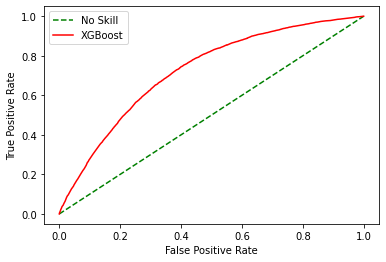

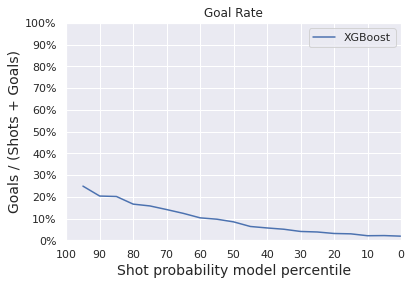

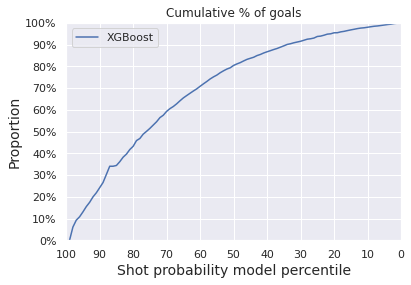

<Figure size 576x360 with 0 Axes>

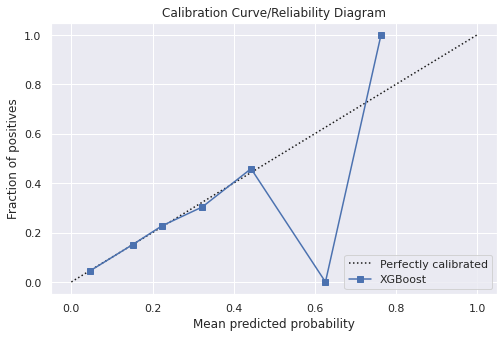

<Figure size 576x360 with 0 Axes>

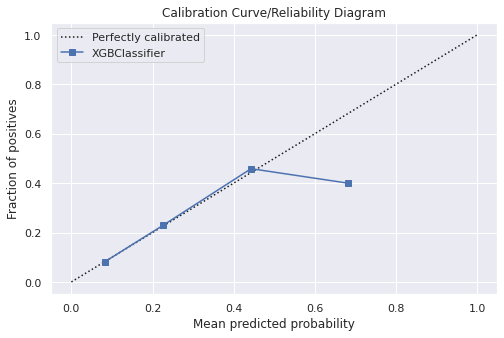

<Figure size 576x360 with 0 Axes>

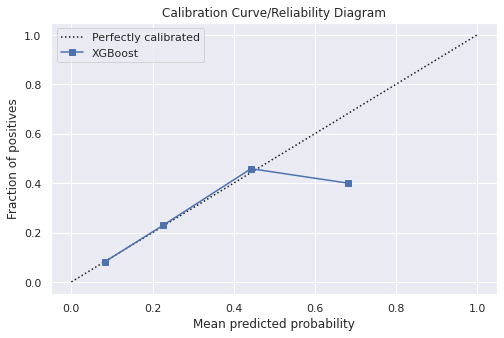

Fitting 3 folds for each of 5 candidates, totalling 15 fits


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/anshitasaxena/milestone-project-2/ad83581278f0420da0e17f1b79f5bcec
COMET INFO:   Metrics:
COMET INFO:     XGBoost Base accuracy:  : 0.9051298701298701
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1huonIANc1xCskpSzNtVFjfLsIVreaVyG
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 6
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (66.71 KB)
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has bee

Statistics for More Features Model-
Accuracy: 90.65%
No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.757


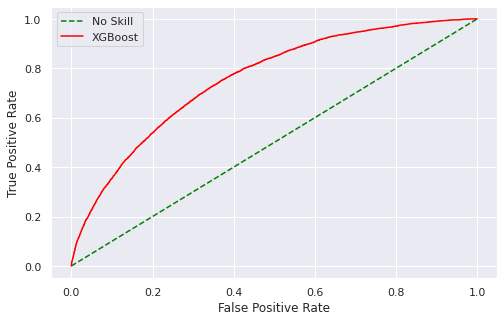

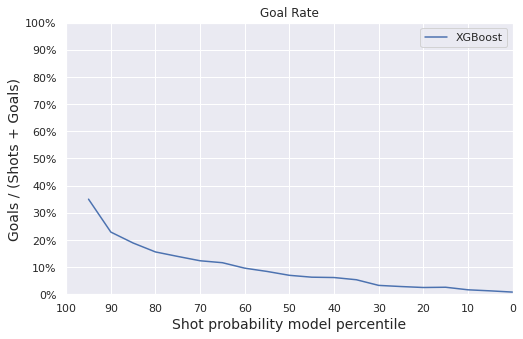

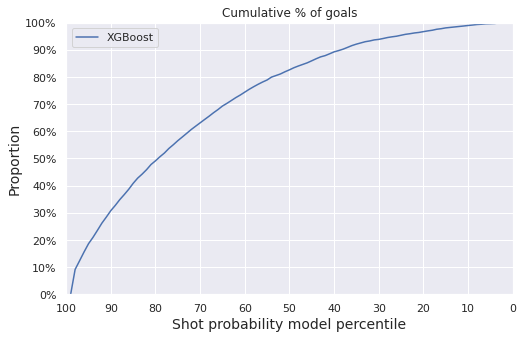

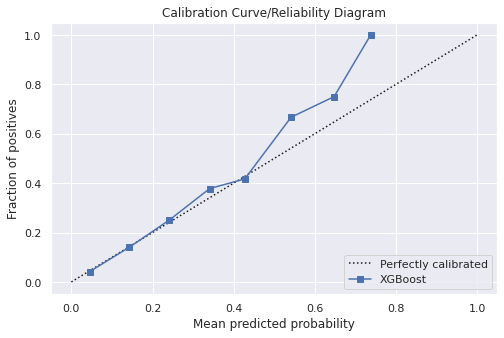

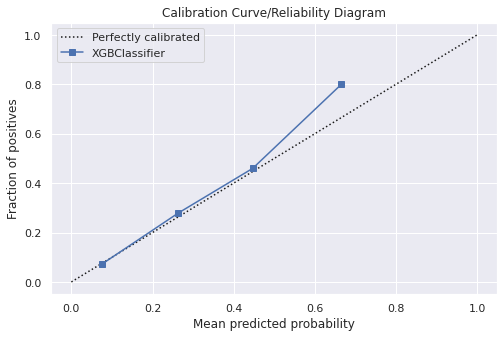

Fitting 3 folds for each of 5 candidates, totalling 15 fits


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, shap, xgboost, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 1.5, 'colsample_bytree': 0.6}
Statistics for Tuned Model-


COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/anshitasaxena/milestone-project-2/c6487221840a43d68087999ed9d21a84



Accuracy: 90.51%
No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.763


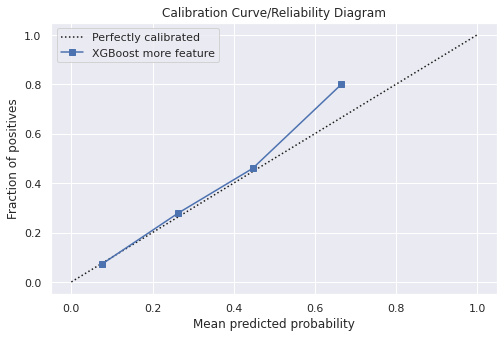

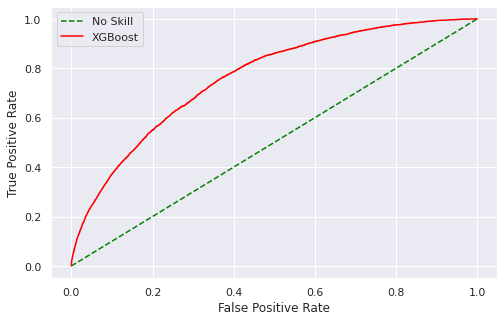

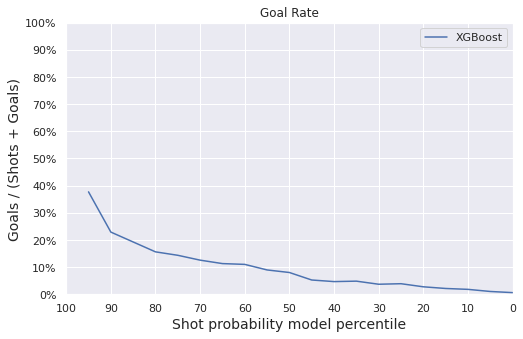

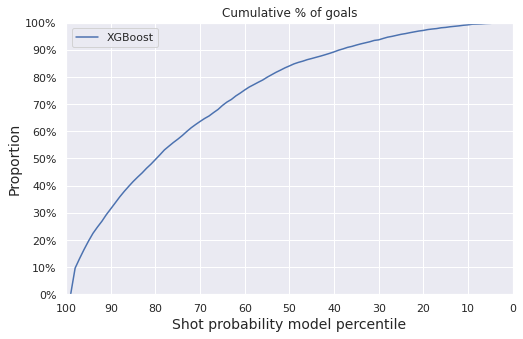

<Figure size 576x360 with 0 Axes>

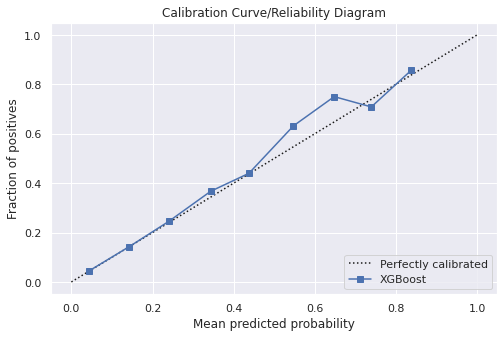

<Figure size 576x360 with 0 Axes>

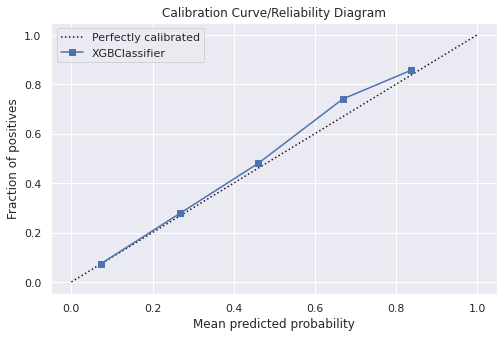

<Figure size 576x360 with 0 Axes>

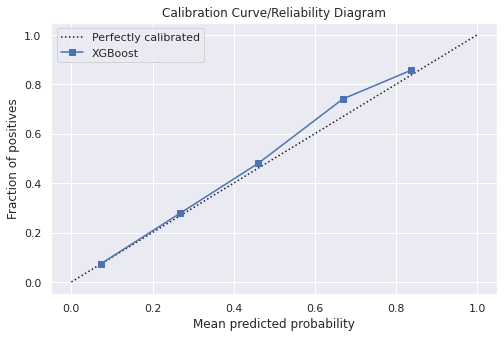

[I 2022-11-13 13:08:54,400] A new study created in memory with name: no-name-44fe9830-30e3-4751-b394-ae7b129e0980
[I 2022-11-13 13:09:15,267] Trial 0 finished with value: 0.7410273622925193 and parameters: {'max_depth': 19, 'min_child_weight': 15, 'eta': 4.469267976845313e-06, 'n_estimators': 813.4908818463997}. Best is trial 0 with value: 0.7410273622925193.
[I 2022-11-13 13:09:20,177] Trial 1 finished with value: 0.7336601471774404 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'eta': 2.097031797200533e-06, 'n_estimators': 855.2667664783467}. Best is trial 0 with value: 0.7410273622925193.
[I 2022-11-13 13:09:40,910] Trial 2 finished with value: 0.7420927219989774 and parameters: {'max_depth': 23, 'min_child_weight': 21, 'eta': 0.00013547131518186297, 'n_estimators': 555.6713574337214}. Best is trial 2 with value: 0.7420927219989774.
[I 2022-11-13 13:09:58,856] Trial 3 finished with value: 0.7421063919473169 and parameters: {'max_depth': 17, 'min_child_weight': 16, 'eta': 1

Number of finished trials:  55
Best trial:
  Value: 0.7612592563321808
  Params: 
    max_depth: 9
    min_child_weight: 18
    eta: 0.3046362037044597
    n_estimators: 289.8115917562731
Number of finished trials: 55
Best trial:
  Value: 0.7612592563321808
  Params:     n_estimators: 289.8115917562731


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/anshitasaxena/milestone-project-2/c6487221840a43d68087999ed9d21a84
COMET INFO:   Metrics:
COMET INFO:     XGBoost Tuned Accuracy:  : 0.9050974025974026
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1huonIANc1xCskpSzNtVFjfLsIVreaVyG
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 6
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (1.26 MB)
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has bee

Features Selection-


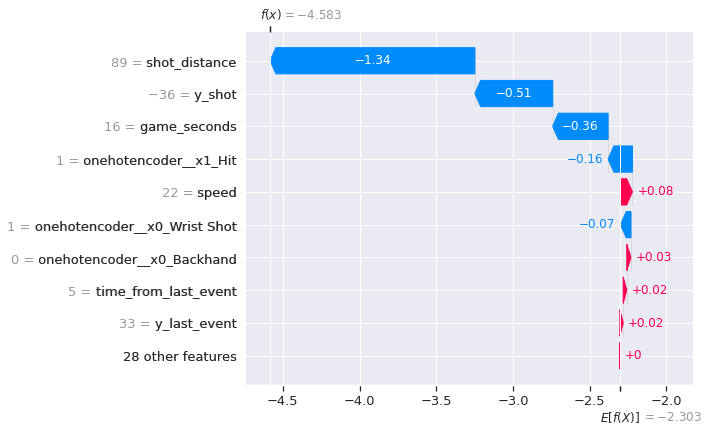

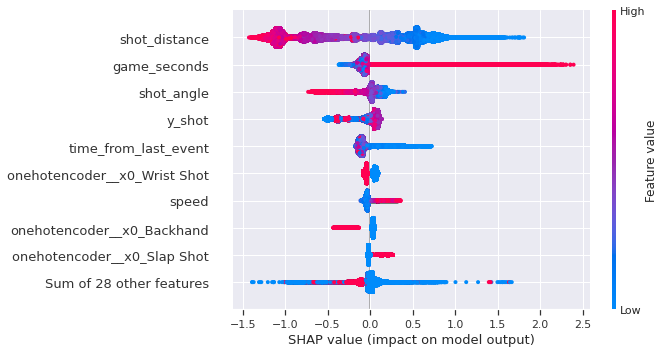

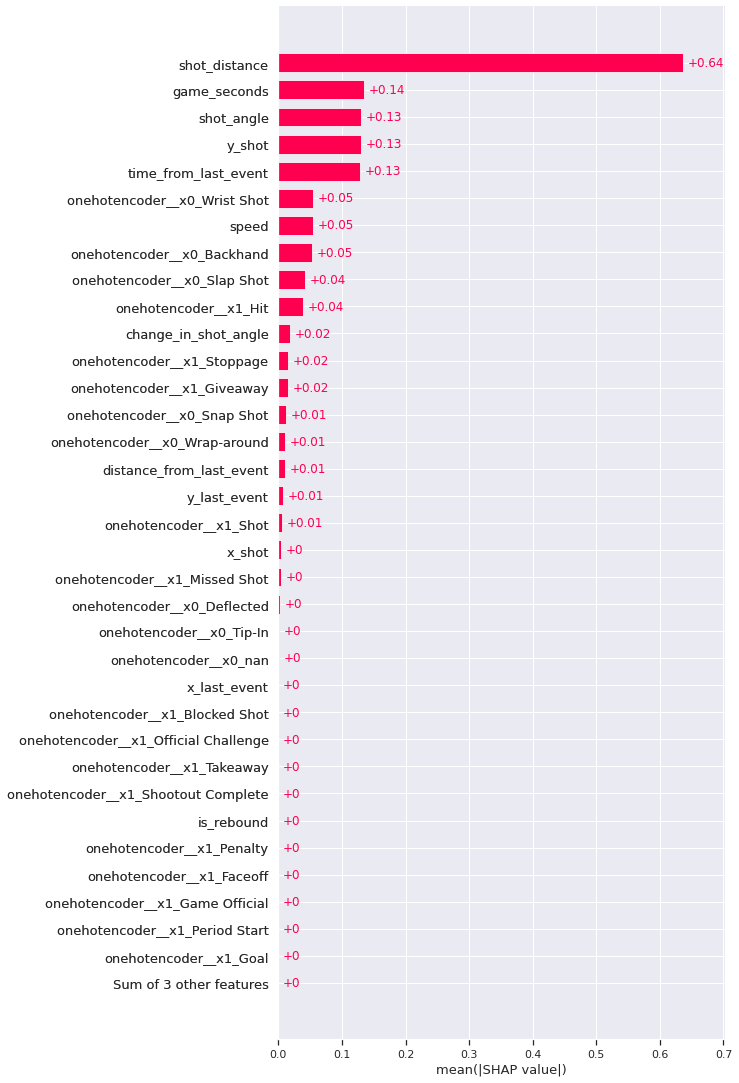

Accuracy: 90.74%
No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.731
Accuracy: 90.36%
No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.572


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, shap, xgboost, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


Index(['onehotencoder__x0_Backhand', 'onehotencoder__x0_Deflected',
       'onehotencoder__x0_Slap Shot', 'onehotencoder__x0_Snap Shot',
       'onehotencoder__x0_Tip-In', 'onehotencoder__x0_Wrap-around',
       'onehotencoder__x0_Wrist Shot', 'onehotencoder__x1_Blocked Shot',
       'onehotencoder__x1_Faceoff', 'onehotencoder__x1_Giveaway',
       'onehotencoder__x1_Hit', 'onehotencoder__x1_Missed Shot',
       'onehotencoder__x1_Shot', 'onehotencoder__x1_Takeaway', 'game_seconds',
       'shot_distance', 'shot_angle', 'period', 'x_shot', 'y_shot',
       'x_last_event', 'y_last_event', 'time_from_last_event',
       'distance_from_last_event', 'is_rebound', 'change_in_shot_angle',
       'speed'],
      dtype='object')
<class 'pandas.core.indexes.base.Index'>


COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/anshitasaxena/milestone-project-2/e1a74e5c03a84373bbbc51af0f968032



XGBClassifier(colsample_bytree=0.8, gamma=1.5, learning_rate=0.05, max_depth=4,
              min_child_weight=5, n_estimators=600, nthread=1, silent=False,
              subsample=0.6)
Accuracy: 90.99%
Model with feature selection-
No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.761


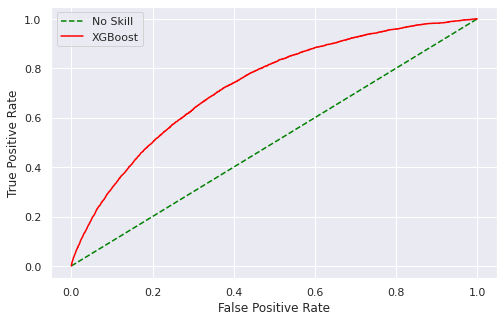

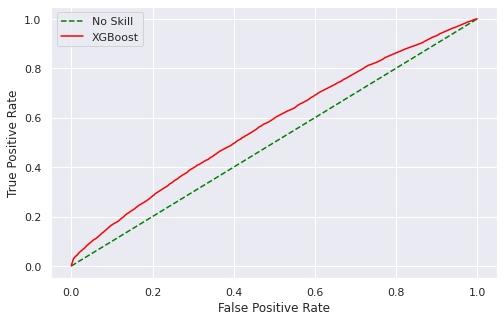

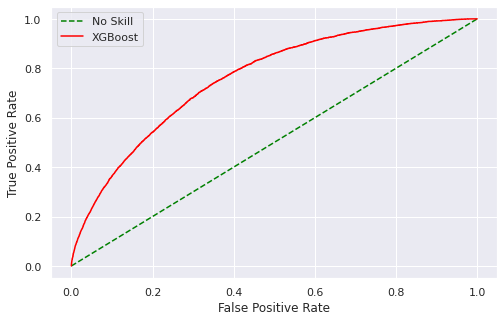

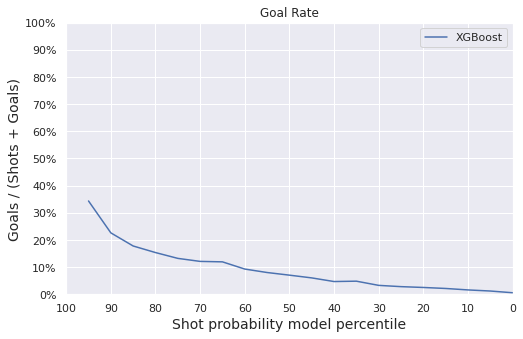

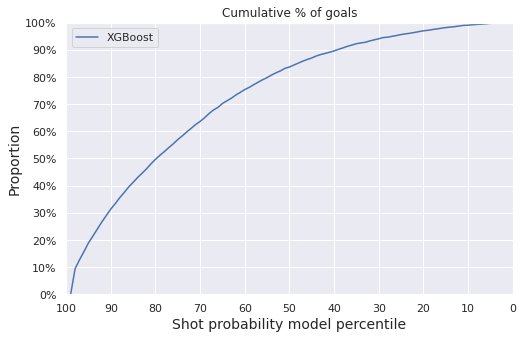

<Figure size 576x360 with 0 Axes>

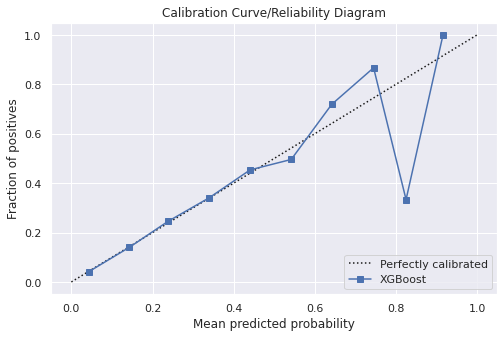

<Figure size 576x360 with 0 Axes>

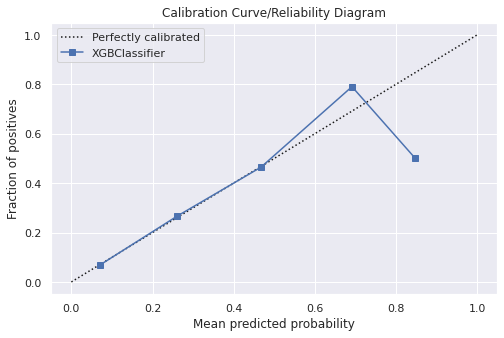

<Figure size 576x360 with 0 Axes>

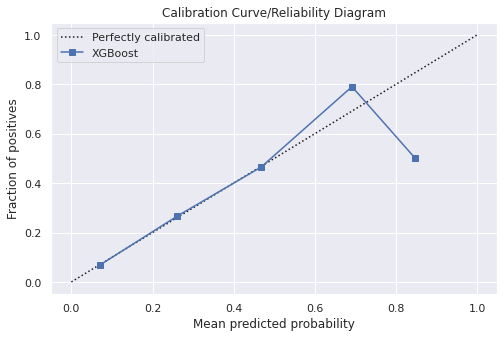

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/anshitasaxena/milestone-project-2/e1a74e5c03a84373bbbc51af0f968032
COMET INFO:   Metrics:
COMET INFO:     XGBoost Feature Selection Accuracy:  : 0.9098881566812549
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1huonIANc1xCskpSzNtVFjfLsIVreaVyG
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 6
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (671.79 KB)
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality

In [ ]:
if __name__ == "__main__":
    main()

**FINISHED**